In [1]:
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/nfshome/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

Z_MASS = 91.2


# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [2]:
fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()
year = 2016
cat = 2


# greater than one lepton, lepton 27 GeV cut, greater than 2 jets

# fpath_bkg['QCD'] = bkg_path+"QCD_HT50toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root"
fpath_bkg['2016'] = "/storage/user/christiw/login-1/christiw/LLP/CMSSW_8_0_21/src/cms_lpc_llp/llp_ntupler/displacedJetMuon_ntupler_RunIISummer16_v8.root"


fpath_bkg['2017'] = "/storage/user/christiw/login-1/christiw/LLP/CMSSW_9_4_7/src/cms_lpc_llp/llp_ntupler/ntuples/displacedJetMuon_ntupler_RunIIFall17_v8_2.root"
fpath_bkg['2018'] = "/storage/user/christiw/login-1/christiw/LLP/CMSSW_10_2_16/src/cms_lpc_llp/llp_ntupler/ntuples/displacedJetMuon_ntupler_RunIIFall18_v8.root"




NEvents = {}


for k,v in fpath_bkg.items():
    print (k, v)
#     tree[k] = rtnp.root2array(v)
    root_dir = uproot.open(v) 
    tree_bkg[k] = root_dir['ntuples']['llp']
#     NEvents[k] = root_dir['NEvents'][1]
#     tree[k] = root_dir['ntuples']
#     a = tree_bkg[k]["weight"].array()
#     print ('weights',np.unique(a)*lumi)
#     print(len(a))
#     print(len(a)/ NEvents[k])
#     print(a.shape)


2016 /storage/user/christiw/login-1/christiw/LLP/CMSSW_8_0_21/src/cms_lpc_llp/llp_ntupler/displacedJetMuon_ntupler_RunIISummer16_v8.root
2017 /storage/user/christiw/login-1/christiw/LLP/CMSSW_9_4_7/src/cms_lpc_llp/llp_ntupler/ntuples/displacedJetMuon_ntupler_RunIIFall17_v8_2.root
2018 /storage/user/christiw/login-1/christiw/LLP/CMSSW_10_2_16/src/cms_lpc_llp/llp_ntupler/ntuples/displacedJetMuon_ntupler_RunIIFall18_v8.root


# Load trigger

In [11]:

pdgId = 13

trigger_names_file = '/nfshome/christiw/llp/delayed_jet_analyzer/data/trigger_names_llp_v1.dat'
trigger_names = []
with open(trigger_names_file) as f:
    reader = csv.reader(f, delimiter=" ")
    for line in reader:
        trigger_names.append(line[2])
if cat==1:
    if pdgId == 13: trigger_paths = [135]
    else:
        if year == 2016:
            trigger_paths = [79]
        else:
            trigger_paths = [87]
#     trigger_paths = [79, 87,135]
elif cat==2:
    if pdgId==13:
        trigger_paths = [177, 179, 135] #everything before 177 are prescaled
#     trigger_paths = [177,362,87,135] #PFMET120
#     trigger_paths = [167, 168,171, 172, 175,176,177,362,87,135] #PFMET120


# 177 HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ
# 362 HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ
# 310 HLT_PFMET120_PFMHT120_IDTight
# 87 HLT_Ele32_WPTight_Gsf
# 135 HLT_IsoMu24
# 310 PFMET
# xsec = {}
# xsec['bbbb10m'] = (5.328E-01 + 8.4E-01) *0.324
# xsec['bbbb1m'] = (5.328E-01 + 8.4E-01) *0.324
# xsec['bbbb0.1m'] = (5.328E-01 + 8.4E-01) *0.324


# xsec['WJetsToLNu'] = 61526.7

legend = {}
legend['bbbb10m'] = 'signal c#tau = 10 m'
legend['bbbb1m'] = 'signal c#tau = 1 m'
legend['bbbb0.1m'] = 'signal c#tau = 0.1 m'

legend['DYJetsToLL'] = 'DYJetsToLL'
legend['WJetsToLNu'] = 'WJetsToLNu'

# Helper Functions

In [ ]:
import math
def deltaPhi( phi1,  phi2):

    dphi = phi1-phi2
    while (dphi > math.pi):
        dphi -= 2*math.pi
  
    while (dphi <= -math.pi):
        dphi += 2*math.pi
    return dphi
def deltaR(eta1, phi1, eta2, phi2):
    dphi = deltaPhi(phi1,phi2)
    deta = eta1 - eta2
    return (dphi*dphi + deta*deta)**0.5

# nCsc with different hit vetoing

In [5]:
%%time

JET_PT_CUT = 10
MUON_PT_CUT = 20
nCscSeg = {}
nCscRechit = {}
cscRechitClusterSize = {}
nCscWireDigis = {}
nCscStripDigis = {}
nDTRechits = {}
nCscRechitCluster_JetMuonVetoCluster0p4_Me1112Veto = {}
for k,T in tree_bkg.items():



    ########### SELECTION: EVENTS ############
    sel_rechitcluster = T.array('cscRechitClusterMaxStationRatio') > 0.1
    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitClusterJetVetoPt') < JET_PT_CUT)
    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitClusterMuonVetoPt') < MUON_PT_CUT)
#     sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitClusterMe11Ratio') < 0.01)
#     sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitClusterMe12Ratio') < 0.01)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, np.abs(T.array('cscRechitClusterMaxChamber')) > 12)
    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitClusterTime') < 22)
    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitClusterTime') > -12.5)
#     sel_ev = np.logical_or(T.array('gLLP_csc')[:,0],T.array('gLLP_csc')[:,1] )

    sel_ev = np.sum(T.array('gLLP_csc'),axis = 1) == 0
    decay_distance0 = np.sqrt(T.array('gLLP_decay_vertex_x')[:,0]**2 + T.array('gLLP_decay_vertex_y')[:,0]**2 + T.array('gLLP_decay_vertex_z')[:,0]**2)
    decay_distance1 = np.sqrt(T.array('gLLP_decay_vertex_x')[:,1]**2 + T.array('gLLP_decay_vertex_y')[:,1]**2 + T.array('gLLP_decay_vertex_z')[:,1]**2)
    cond1 = np.logical_and(decay_distance0 < 200, decay_distance1 < 200)
    cond2 = np.logical_and(np.abs(T.array('gLLP_decay_vertex_z')[:,0]) > 1200, np.abs(T.array('gLLP_decay_vertex_z')[:,1]) > 1200)
    sel_ev = np.logical_and(sel_ev, np.logical_or(cond1, cond2))
    
    cscRechitClusterSize[k] = T.array('cscRechitClusterSize')[sel_rechitcluster][sel_ev]
    nCscRechitCluster_JetMuonVetoCluster0p4_Me1112Veto[k] = cscRechitClusterSize[k].sum()


    nCscSeg[k] = T.array('nCscSeg') [sel_ev]
    nCscRechit[k] = T.array('ncscRechits') [sel_ev]
    nCscWireDigis[k] = T.array('nCscWireDigis') [sel_ev]
    nCscStripDigis[k] = T.array('nCscStripDigis') [sel_ev]
    nDTRechits[k] = T.array('nDtRechits') [sel_ev]






CPU times: user 34.7 s, sys: 996 ms, total: 35.7 s
Wall time: 1min 12s


# in time clusters

In [ ]:
start_t = time.time()
JET_PT_CUT = 10
MUON_PT_CUT = 20


weight = {}
weight_event = {}
lumiSec = {}
evtNum = {}
nCsc = {}
npv = {}
npu = {}
runNum = {}
nCsc_JetVetoCluster0p4 = {}
nCsc_JetVetoCluster0p4_Me1112Veto = {}
nCsc_JetMuonVetoCluster0p4 = {}
nCsc_JetMuonVetoCluster0p4_Me1112Veto = {}
nCsc_JetMuonEventVetoCluster0p4_Me1112Veto = {}
nCsc_JetMuonEventVetoITCluster0p4_Me1112Veto = {}

nCsc0_JetMuonVetoCluster0p4_Me1112Veto = {}

nCsc_caloJetMuonVetoCluster0p4_Me1112Veto = {}
nCsc_caloJetVetoCluster0p4_Me1112Veto = {}
nCsc_caloJetMuonVetoCluster0p4 = {}
nCsc_caloJetVetoCluster0p4 = {}
nCsc_calopfJetMuonVetoCluster0p4_Me1112Veto = {}
nCscClusters = {}
cscClusterR = {}
cscClusterX = {}
cscClusterY = {}
cscClusterZ = {}
cscClusterEta = {}
cscClusterPhi = {}
cscClusterMajorAxis = {}
cscClusterMinorAxis = {}
cscClusterRadius = {}
cscClusterSize = {}
nCscClusters = {}
cscClusterAxis = {}
cscClusterEtaPhiSpread = {}
cscClusterPhiSpread = {}
cscClusterEtaSpread = {}
# nSegments_cluster = {}
cscClusterXSpread = {}
cscClusterYSpread = {}
cscClusterZSpread = {}
cscClusterXYSpread = {}
cscClusterTime = {}
cscClusterTimeSpread = {}
cscClusterMe1112hits = {}
cscClusterSeparation = {}
gLLP_eta = {}
gLLP_r = {}
gLLP_z = {}
cscClusterSizeRatio = {}
cscITClusterSize = {}
cscClusterVertexChi2 = {}
cscClusterMe1112Ratio  = {}
cscClusterMaxStationRatio  = {}
cscClusterGenMuonDeltaR  = {}
cscClusterNStation = {}
cscClusterNLayer = {}
cscClusterMaxLayerRatio = {}
nCsc_MuonVetoCluster0p4_Me1112Veto = {}
weight_wjetveto = {}
for k,T in tree_bkg.items():
    
########### SELECTION: CLUSTERS ############
#     cscClusterX[k] = T.array('cscClusterX')[sel_ev]
#     cscClusterY[k] = T.array('cscClusterY')[sel_ev]
#     cscClusterR[k] = np.sqrt(np.square(cscClusterX[k])+np.square(cscClusterY[k]))
    sel_cluster =  T.array('cscITClusterMuonVeto') < MUON_PT_CUT
    sel_cluster = np.logical_and( sel_cluster,T.array('cscITClusterJetVeto') < JET_PT_CUT )
    sel_cluster = np.logical_and( sel_cluster, T.array('cscITClusterMe1112Ratio') < 0.01)
    sel_cluster = np.logical_and( sel_cluster, np.abs(T.array('cscITClusterMaxStation')) != 11)
    sel_cluster = np.logical_and( sel_cluster, np.abs(T.array('cscITClusterMaxStation')) != 12)
    sel_cluster = np.logical_and(sel_cluster, T.array('cscITClusterMaxLayerRatio')*T.array('cscITClusterSize') > 5.01)
    sel_cluster = np.logical_and(sel_cluster, T.array('cscITClusterNLayer') == 1)
#     sel_cluster_wjetveto = np.logical_and( sel_cluster, T.array('cscITClusterJetVeto') < JET_PT_CUT)


   
#     sel_cluster = np.logical_and( sel_cluster, T.array('cscClusterTimeSpread') < 10)
#     etaPhiSpread = np.sqrt(T.array('cscClusterPhiSpread')**2+T.array('cscClusterEtaSpread')**2)
#     sel_cluster = np.logical_and( sel_cluster, etaPhiSpread > 0.05)

#     sel_cluster = np.logical_and( sel_cluster, np.abs(T.array('cscClusterStation')) != 12)
#     sel_cluster = np.logical_and( sel_cluster, np.abs(T.array('cscClusterStation')) != 11)
#     sel_itcluster = T.array('cscITClusterJetVeto') < JET_PT_CUT
#     sel_itcluster = np.logical_and( sel_itcluster, T.array('cscITClusterMuonVeto') < MUON_PT_CUT)
#     sel_itcluster = np.logical_and( sel_itcluster, np.abs(T.array('cscITClusterStation')) != 12)
#     sel_itcluster = np.logical_and( sel_itcluster, np.abs(T.array('cscITClusterStation')) != 11)

########### SELECTION: EVENTS ############
    hlt = T['HLTDecision'].array()
    # select only triggered events
    sel_ev= np.ones(hlt[:,0].shape, dtype=bool)
    sel_ev= np.zeros(hlt[:,0].shape)
    for tr in trigger_paths:
        sel_ev  = np.logical_or(sel_ev,hlt[:,tr])
    sel_muon = np.logical_and(T.array('lepPassId'), T.array('lepPt')>=25)
    sel_muon = np.logical_and(sel_muon, np.abs(T.array('lepEta'))<2.4)
    sel_muon = np.logical_and(sel_muon, np.abs(T.array('lepPdgId')) == 13)

    sel_ele = np.logical_and(T.array('lepPassId'), T.array('lepPt')>=35)
    sel_ele = np.logical_and(sel_ele, np.abs(T.array('lepEta'))<2.4)
    sel_ele = np.logical_and(sel_ele, np.abs(T.array('lepPdgId')) == 11)
    
    sel_lep = np.logical_or(sel_ele, sel_muon)
    sel_ev = np.logical_and(sel_ev, sel_lep.sum() == 1)
    


    ##### jet veto #####
    sel_jetveto = np.logical_and(sel_ev, (sel_cluster.sum()) >= 1)
#     sel_jetveto = np.logical_and(sel_jetveto, T.array('cscITClusterNLayer')[sel_cluster].sum() >= 1 )
#     sel_jetveto = np.logical_and(sel_jetveto, T.array('cscITClusterNLayer')[sel_cluster].sum() > 1 )
#     sel_wjetveto = np.logical_and(sel_ev, (sel_cluster_wjetveto.sum()) >= 1)
#     sel_wjetveto = np.logical_and(sel_jetveto, T.array('cscITClusterNLayer')[sel_cluster_wjetveto].sum() >= 1 )

    ##### event veto #####
    sel_eventveto =  np.logical_and(sel_ev, (np.logical_not(sel_cluster).sum()) == 0)
    
    ##### LLP selection #####
    if not k == 'WJetsToLNu':
        gLLP_eta[k] = T.array('gLLP_eta')
        gLLP_r[k] = T.array('gLLP_decay_vertex_r')
        gLLP_z[k] = T.array('gLLP_decay_vertex_z')
        sel_llp = np.logical_and(np.abs(gLLP_eta[k])<2.4, np.abs(gLLP_eta[k])>0.9)
        sel_llp = np.logical_and(sel_llp, np.abs(gLLP_z[k])<1100)
        sel_llp = np.logical_and(sel_llp, np.abs(gLLP_z[k])>568)
        sel_llp = np.logical_and(sel_llp,gLLP_r[k] < 695.5)
        sel_llp = np.sum(sel_llp,axis=1) >= 1
        print (k)
        print("selected+in csc",lumi*np.sum(T.array('weight')[np.logical_and(sel_llp, sel_jetveto)]))
        print("trigged+in csc",lumi*np.sum(T.array('weight')[np.logical_and(sel_llp, sel_ev)]))
        print("triggered",lumi*np.sum(T.array('weight')[sel_ev]))
        print("selected", lumi*np.sum(T.array('weight')[ sel_jetveto]))
        print("at least 1 LLP in csc",lumi*np.sum(T.array('weight')[ sel_llp]))
        print("xsec",lumi*np.sum(T.array('weight')))

########### BRANCHES ############

   
    ##### clusters #####
    cscClusterXSpread[k] =  T.array('cscITClusterXSpread')[sel_cluster][sel_jetveto]
    cscClusterYSpread[k] =  T.array('cscITClusterYSpread')[sel_cluster][sel_jetveto]
    cscClusterZSpread[k] =  T.array('cscITClusterZSpread')[sel_cluster][sel_jetveto]
    cscClusterEtaSpread[k] =  T.array('cscITClusterEtaSpread')[sel_cluster][sel_jetveto]
    cscClusterPhiSpread[k] =  T.array('cscITClusterPhiSpread')[sel_cluster][sel_jetveto]
    cscClusterEtaPhiSpread[k] = np.sqrt(cscClusterEtaSpread[k]**2+cscClusterPhiSpread[k]**2)
 
    cscClusterTime[k] = T.array('cscITClusterTime')[sel_cluster][sel_jetveto]
    cscClusterTimeSpread[k] = T.array('cscITClusterTimeSpread')[sel_cluster][sel_jetveto]
    cscClusterXYSpread[k] = np.sqrt(cscClusterXSpread[k]*cscClusterXSpread[k]+cscClusterYSpread[k]*cscClusterYSpread[k])[:,0]
    nCscClusters[k] = T.array('cscITClusterXSpread')[sel_cluster][sel_jetveto].count()
    cscClusterSize[k] =  T.array('cscITClusterSize')[sel_cluster][sel_jetveto]
    cscClusterEta[k] =  T.array('cscITClusterEta')[sel_cluster][sel_jetveto]
    cscClusterPhi[k] =  T.array('cscITClusterPhi')[sel_cluster][sel_jetveto]
    cscClusterX[k] =  T.array('cscITClusterX')[sel_cluster][sel_jetveto]
    cscClusterY[k] =  T.array('cscITClusterY')[sel_cluster][sel_jetveto]
    cscClusterZ[k] =  T.array('cscITClusterZ')[sel_cluster][sel_jetveto]
    cscClusterR[k] = np.sqrt(cscClusterX[k]**2+cscClusterY[k]**2)
#     cscClusterMe1112hits[k] =  T.array('cscClusterMe1112hits')[sel_cluster][sel_jetveto]
#     cscClusterVertexChi2[k] = T.array('cscClusterVertexChi2')[sel_cluster][sel_jetveto]
    cscClusterMe1112Ratio[k]  = T.array('cscITClusterMe1112Ratio')[sel_cluster][sel_jetveto]
    cscClusterMaxStationRatio[k]  = T.array('cscITClusterMaxStationRatio')[sel_cluster][sel_jetveto]
    cscClusterGenMuonDeltaR[k]  = T.array('cscITClusterGenMuonDeltaR')[sel_cluster][sel_jetveto]
    cscClusterNStation[k]  = T.array('cscITClusterNStation')[sel_cluster][sel_jetveto]
    cscClusterNLayer[k]  = T.array('cscITClusterNLayer')[sel_cluster][sel_jetveto]
    cscClusterNLayer[k]  = cscClusterNLayer[k].sum()


    cscClusterMaxLayerRatio[k] = T.array('cscITClusterMaxLayerRatio')[sel_cluster][sel_jetveto]


    
    ##### event variables #####
    lumiSec[k] = T.array('lumiSec')[sel_jetveto]
    evtNum[k] = T.array('evtNum')[sel_jetveto]
    runNum[k] = T.array('runNum')[sel_jetveto]
    weight[k] = T.array('weight')[sel_jetveto]*lumi
    weight_event[k] = T.array('weight')[sel_eventveto]*lumi
    nCsc[k] =T.array('nCsc')[sel_jetveto]
    npv[k] = T.array('npv')[sel_jetveto]
    npu[k] = T.array('npu')[sel_jetveto]


    ##### calo jets #####
#     nCsc_caloJetVetoCluster0p4_Me1112Veto[k] = T.array('nCsc_caloJetVetoCluster0p4_Me1112Veto')[sel_ev]
#     nCsc_caloJetMuonVetoCluster0p4_Me1112Veto[k] = T.array('nCsc_caloJetMuonVetoCluster0p4_Me1112Veto')[sel_ev]
#     nCsc_caloJetVetoCluster0p4[k] = T.array('nCsc_caloJetVetoCluster0p4')[sel_ev]
#     nCsc_caloJetMuonVetoCluster0p4[k] = T.array('nCsc_caloJetMuonVetoCluster0p4')[sel_ev]

   
    ##### jet veto #####
    temp = T.array('cscITClusterSize')
    nCsc_JetVetoCluster0p4[k] =T.array('nCsc_JetVetoITCluster0p4')[sel_jetveto]
    nCsc_JetVetoCluster0p4_Me1112Veto[k] =T.array('nCsc_JetVetoITCluster0p4_Me1112Veto')[sel_jetveto]
    
    nCsc0_JetMuonVetoCluster0p4_Me1112Veto[k] =temp[sel_cluster][sel_jetveto][:,0]
#     nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] = T.array('nCsc_JetMuonVetoCluster0p4_Me1112Veto')[sel_jetveto]
    nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] =  T.array('cscITClusterSize')[sel_cluster][sel_jetveto].sum()
#     nCsc_JetMuonVetoITCluster0p4_Me1112Veto[k] = cscITClusterSize[k].sum()
    nCsc_JetMuonVetoCluster0p4[k] =  T.array('nCsc_JetMuonVetoITCluster0p4')[sel_jetveto]
    
#     nCsc_MuonVetoCluster0p4_Me1112Veto[k] =  T.array('cscITClusterSize')[sel_cluster][sel_jetveto].sum()


    
    ##### event pick print out #####
#     if k == 'bbbb10m':
#         for i in range(len(lumiSec[k])):
#             if nCsc_JetMuonVetoCluster0p4_Me1112Veto[k][i]>100:
#                 print("{0}:{1}:{2}".format(str(runNum[k][i]),str(lumiSec[k][i]),str(evtNum[k][i])))
#     if k == 'bbbb10m':
#         print(cscClusterEta[k][nCscClusters[k]>1])
#         print(cscClusterPhi[k][nCscClusters[k]>1])
#         print(cscClusterSize[k][nCscClusters[k]>1])
#         print(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k][nCscClusters[k]>1])

    print(k,np.sum(weight[k]))
    print (k,np.sum(weight[k][nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>57])/(xsec[k]*lumi))
print(time.time()-start_t)

# 1D histogram

0.012884140014648438


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: 2016 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: 2017 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: 2018 (Potential memory leak).


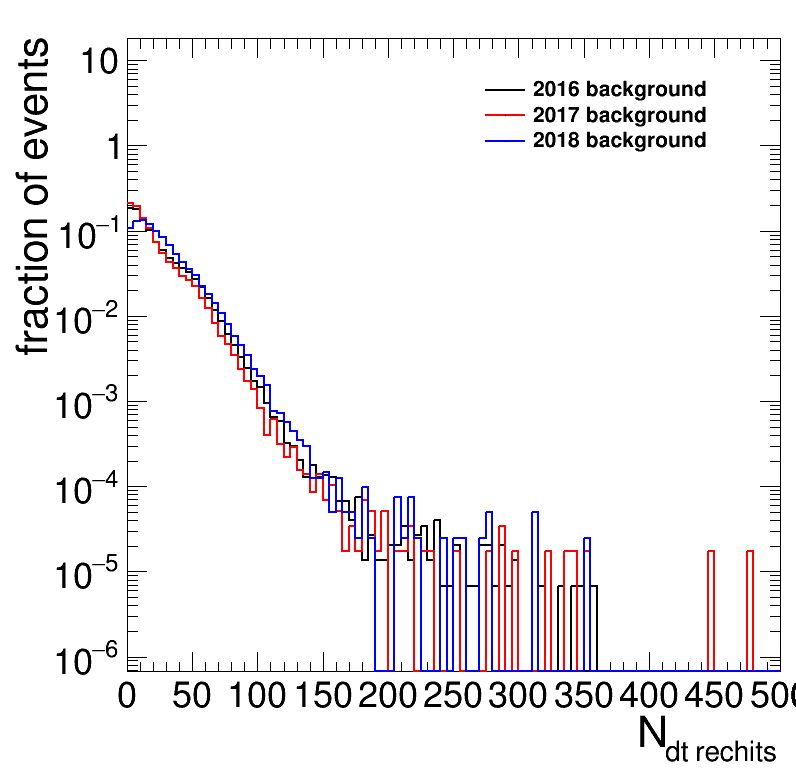

In [8]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 800, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.60,0.80,0.88,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)
maximum = 0
i = 0
for k,v in nCscSeg.items():

#     h[k] = create_TH1D( nCscSeg[k], axis_title=['N_{segments}', 'fraction of events'], name=k, binning=[100,0,400])
#     h[k] = create_TH1D( nCscRechit[k], axis_title=['N_{rechit}', 'fraction of events'], name=k, binning=[100,0,1000])
    h[k] = create_TH1D( nCscRechitCluster_JetMuonVetoCluster0p4_Me1112Veto[k].flatten(), axis_title=['N_{rechit}', 'fraction of events'], name=k, binning=[50,0,500])

#     h[k] = create_TH1D( nCscWireDigis[k].flatten(), axis_title=['N_{wire digis}', 'fraction of events'], name=k, binning=[100,0,1000])
#     h[k] = create_TH1D( nCscStripDigis[k].flatten(), axis_title=['N_{strip digis}', 'fraction of events'], name=k, binning=[100,0,1000])
    h[k] = create_TH1D( nDTRechits[k].flatten(), axis_title=['N_{dt rechits}', 'fraction of events'], name=k, binning=[100,0,500])






    h[k].SetLineColor(std_color_list[i])
#     h[k+'it'].SetLineColor(std_color_list[i])
#     h[k+'it'].SetLineStyle(2)


    leg.AddEntry(h[k], k+" background")
#     leg.AddEntry(h[k+'it'], legend[k]+" in time")

    h[k].SetMinimum(0.1)

    maximum = max(maximum, h[k].GetMaximum() )
    h[k].SetMaximum(maximum * 100)
    #     h[k+'it'].SetMaximum(10000/8)

#     if k[:4] == 'bbbb':
#         h[k].Draw('same hist')
    h[k].DrawNormalized('same hist')


#     h[k].GetXaxis()


    i+=1
leg.Draw()


# if setlog: 
c.SetLogy()
c.Draw()
print(time.time()-start_t)

# 2D plots

In [ ]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 1000, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.58,0.70,0.94,0.85)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)

i = 0
k = 'bbbb10m'
k = 'WJetsToLNu'
# h[k] = create_TH2D(np.column_stack((cscClusterXSpread[k].flatten(),cscClusterYSpread[k].flatten())), axis_title = ['#sigma_{x}','#sigma_{y}','Events'], binning=[50,0,100,50,0,100])
# h[k] = create_TH2D(np.column_stack((cscClusterXSpread[k].flatten(),nCsc_JetMuonVetoCluster0p4_Me1112Veto[k].flatten())), axis_title = ['#sigma_{x}','nCsc','Events'], binning=[50,0,100,50,0,300])
# h[k] = create_TH2D(np.column_stack((cscTime[k].flatten(),nCsc[k].flatten())), axis_title = ['csc time [ns]','nCsc','Events'], binning=[50,-100,100,50,0,300])
# h[k] = create_TH2D(np.column_stack((npv[k],nCsc[k].flatten())), axis_title = ['npv','nCsc','Events'], binning=[50,0,100,50,0,300])
# h[k] = create_TH2D(np.column_stack((npu[k],nCsc_JetMuonVetoCluster0p4_Me1112Veto[k])), axis_title = ['npu','nCsc','Events'], binning=[50,0,100,50,0,300])
# h[k] = create_TH2D(np.column_stack((cscClusterMe1112Ratio[k].flatten(),cscClusterTime[k].flatten())), axis_title = ['Me1112 ratio','cluster time [ns]','Events'], binning=[20,0,1,50,-100,150])
h[k] = create_TH2D(np.column_stack((nJets[k],nCsc_JetMuonVetoCluster0p4_Me1112Veto[k])), axis_title = ['nJets','nCscSegments','Events'], binning=[10,0,10,50,0,150])



# h[k] = create_TH2D(np.column_stack((cscClusterTime[k].flatten(),nCsc_JetMuonVetoCluster0p4_Me1112Veto[k].flatten())), axis_title = ['csc cluster time [ns]','nCsc','Events'], binning=[50,-100,100,50,0,300])
# h[k] = create_TH2D(np.column_stack((cscClusterZSpread[k][:,0].flatten(),nCsc_JetMuonVetoCluster0p4_Me1112Veto[k].flatten())), axis_title = ['#sigma_{z}','nCsc','Events'], binning=[50,0,20,50,0,300])
# h[k] = create_TH2D(np.column_stack((cscClusterXYSpread[k].flatten(),nCsc_JetMuonVetoCluster0p4_Me1112Veto[k].flatten())), axis_title = ['#sigma_{xy}','nCsc','Events'], binning=[50,0,100,20,0,200])

# h[k] = create_TH2D(np.column_stack((cscClusterTimeSpread[k][:,0].flatten(),nCsc_JetMuonVetoCluster0p4_Me1112Veto[k].flatten())), axis_title = ['#sigma_{time} [ns]','nCsc','Events'], binning=[50,0,100,20,0,200])
# h[k] = create_TH2D(np.column_stack((cscClusterEtaSpread[k][:,0].flatten(),nCsc_JetMuonVetoCluster0p4_Me1112Veto[k].flatten())), axis_title = ['#sigma_{time} [ns]','nCsc','Events'], binning=[50,0,0.25,20,0,100])

# h[k] = create_TH2D(np.column_stack((np.abs(cscClusterZ[k].flatten()),cscClusterR[k].flatten())), axis_title = ['Z [cm]','R [cm]','Events'], binning=[100,500,1200,200,0,1000])



# h[k] = create_TH2D(np.column_stack((cscClusterTime[k][:,0],nCsc_JetMuonVetoCluster0p4_Me1112Veto[k].flatten())), axis_title = ['time [ns]','nCsc','Events'], binning=[50,-100,120,50,0,200])

# h[k] = create_TH2D(np.column_stack((np.sqrt(cscClusterTimeSpread[k].flatten()),nCsc_JetMuonVetoCluster0p4_Me1112Veto[k].flatten())), axis_title = ['csc cluster time moment [ns]','nCsc','Events'], binning=[50,0,100,50,0,300])




h[k].SetLineColor(std_color_list[i])
# leg.AddEntry(h[k], k)
#     h[k].SetMaximum(10E5)
#     h[k].SetMinimum(1)
h[k].Draw('colz')
c.SetRightMargin(0.2)



# if setlog: 
c.SetLogz()
c.Draw()
print(time.time()-start_t)

# ROC Curve

(999,) (999,)
bbbb15 cscClusterJetVetoPt 1.1615144731419915
28
(1000,) (1000,)
bbbb15 cscClusterJetVetoE 1.2336313526651994
87
(1000,) (1000,)
bbbb15 cscClusterMuonVetoPt 1.0778208132849612
13
(1000,) (1000,)
bbbb15 cscClusterMuonVetoE 1.0699495213236039
31


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


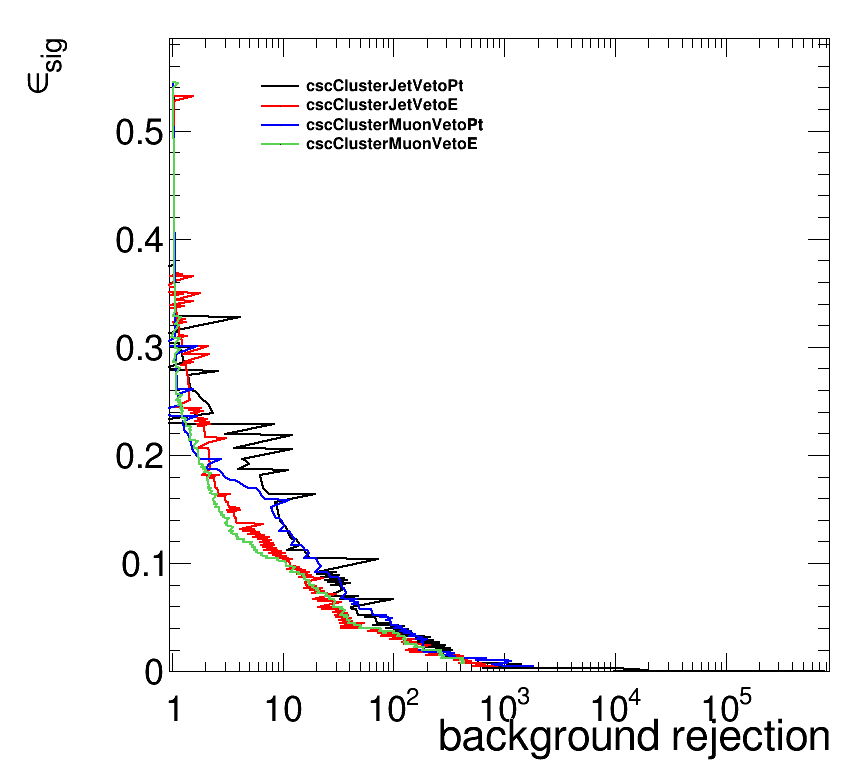

In [31]:
#ROC curve
c = rt.TCanvas('c','c', 850, 800)
leg = rt.TLegend(0.5,0.80,0.85,0.90)
leg = rt.TLegend(0.3,0.80,0.55,0.90)


leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
gr = {}


# var = [nCsc_recoJetVeto0p4,nCsc_recoJetVeto0p8,nCsc_recoJetVeto0p4_Me11Veto,nCsc_recoJetVeto0p8_Me11Veto,
#         nCsc_recoJetVeto0p4_Me1112Veto,nCsc_recoJetVeto0p8_Me1112Veto]
# name = ['nCsc_recoJetVeto0p4','nCsc_recoJetVeto0p8','nCsc_recoJetVeto0p4_Me11Veto','nCsc_recoJetVeto0p8_Me11Veto',
#         'nCsc_recoJetVeto0p4_Me1112Veto','nCsc_recoJetVeto0p8_Me1112Veto']
# # moment_xaxis = ['sig_et1','sig_et2','sig_e1','sig_e2','sig_e','sig_et','etD','eD']
# legend = ['recoJetVeto #Delta R = 0.4','recoJetVeto #Delta R = 0.8','recoJetVeto #Delta R = 0.4, Me11Veto',
#           'recoJetVeto #Delta R = 0.8, Me11Veto','recoJetVeto #Delta R = 0.4, Me11 12Veto',
#           'recoJetVeto #Delta R = 0.8, Me11 12Veto']

# var = [nCsc_recoJetVeto0p4,nCsc_JetVetoCluster0p4,
#         nCsc_recoJetVeto0p4_Me1112Veto,nCsc_JetVetoCluster0p4_Me1112Veto]
# name = ['nCsc_recoJetVeto0p4','nCsc_JetVetoCluster0p4',
#         'nCsc_recoJetVeto0p4_Me1112Veto','nCsc_JetVetoCluster0p4_Me1112Veto']
# legend = ['hit removal', 'cluster removal', 'hit removal + ME11/12 veto','cluster removal + ME11/12 veto']


# # with and without muon veto
# var = [nCsc_JetVetoCluster0p4, nCsc_JetMuonVetoCluster0p4, 
#        nCsc_JetVetoCluster0p4_Me1112Veto,nCsc_JetMuonVetoCluster0p4_Me1112Veto, ]
# name =['nCsc_JetVetoCluster0p4', 'nCsc_JetMuonVetoCluster0p4', 
#        'nCsc_JetVetoCluster0p4_Me1112Veto','nCsc_JetMuonVetoCluster0p4_Me1112Veto', ]
# legend = ['jet veto', 'jet & muon veto', 'jet veto + ME11/12 veto','jet & muon veto + ME11/12 veto', ]

#event veto vs. jet veto
# var = [nCsc_JetMuonEventVetoCluster0p4_Me1112Veto,nCsc0_JetMuonVetoCluster0p4_Me1112Veto, nCsc_JetMuonVetoCluster0p4_Me1112Veto, ]
# name =['nCsc_JetMuonEventVetoCluster0p4_Me1112Veto','nCsc0_JetMuonVetoCluster0p4_Me1112Veto','nCsc_JetMuonVetoCluster0p4_Me1112Veto', ]
# legend = ['event veto','Most populated cluster','jet & muon veto + ME11/12 veto', ]
var = [nCsc_JetMuonVetoCluster0p4_Me1112Veto, ]
name =['nCsc_JetMuonVetoCluster0p4_Me1112Veto', ]
label = ['jet & muon veto + ME11/12 veto', ]

var = [cscClusterJetVetoPt, cscClusterJetVetoE, cscClusterMuonVetoPt,cscClusterMuonVetoE]
name =['cscClusterJetVetoPt', 'cscClusterJetVetoE', 'cscClusterMuonVetoPt', 'cscClusterMuonVetoE', ]
label = ['cscClusterJetVetoPt', 'cscClusterJetVetoE', 'cscClusterMuonVetoPt', 'cscClusterMuonVetoE', ]


#calo vs. pf
# var = [ nCsc_JetMuonVetoCluster0p4_Me1112Veto,nCsc_caloJetMuonVetoCluster0p4_Me1112Veto, nCsc_calopfJetMuonVetoCluster0p4_Me1112Veto]
# name = ['nCsc_JetMuonVetoCluster0p4_Me1112Veto', 'nCsc_caloJetMuonVetoCluster0p4_Me1112Veto', 'nCsc_calopfJetMuonVetoCluster0p4_Me1112Veto']
# legend = ['pf jet & muon veto + ME11/12 veto','calo jet & muon veto + ME11/12 veto','pf & calo jet & muon veto + ME11/12 veto']

#calo jet
# var = [nCsc_caloJetVetoCluster0p4, nCsc_caloJetMuonVetoCluster0p4, 
#        nCsc_caloJetVetoCluster0p4_Me1112Veto,nCsc_caloJetMuonVetoCluster0p4_Me1112Veto, ]
# name =['nCsc_caloJetVetoCluster0p4', 'nCsc_caloJetMuonVetoCluster0p4', 
#        'nCsc_caloJetVetoCluster0p4_Me1112Veto','nCsc_caloJetMuonVetoCluster0p4_Me1112Veto', ]
# legend = ['calojet veto', 'calojet & muon veto', 'calojet veto + ME11/12 veto','calojet & muon veto + ME11/12 veto', ]




# #compare sum vs. most populated cluster

# var = [nCsc0_JetMuonVetoCluster0p4, nCsc0_JetMuonVetoCluster0p4_Me1112Veto, 
#        nCsc_JetMuonVetoCluster0p4,nCsc_JetMuonVetoCluster0p4_Me1112Veto, ]
# name = ['nCsc0_JetMuonVetoCluster0p4', 'nCsc0_JetMuonVetoCluster0p4_Me1112Veto', 
#        'nCsc_JetMuonVetoCluster0p4','nCsc_JetMuonVetoCluster0p4_Me1112Veto', ]
# legend = ['jet & muon veto, largest cluster', 'jet & muon veto + ME11/12 veto, largest cluster', 
# 'jet & muon veto, all clusters', 'jet & muon veto + ME11/12 veto, all clusters']



qcd_key = 'DYJetsToLL'
# sig_k = 'bbbb1m'
thre = np.array(range(1000))
keys = ['bbbb15']
for j,sig_k in enumerate(keys):
    for i in range(len(var)):
        eff = {}

        for k in tree_bkg.keys():
            w = weight[k]+var[i][k]*0.0
            w = w.flatten()
            v = var[i][k].flatten()
            eff[k] = []
            for th in thre:
    #             if k == 'bbbb':
    #                 eff[k].append(1.0*np.sum(weight[k][v>th])/np.sum(weight[k]))
    #             else:
                eff[k].append(1.0*np.sum(w[v>th])/np.sum(w))



#                 eff[k].append(1.0*np.sum(weight[k][v>th])/(xsec[k]*lumi))
    #         print(k,xsec[k]*lumi)

            eff[k] = np.array(eff[k])
    #     Plotting ROC curve
        eff[sig_k] = eff[sig_k][np.logical_not(eff[qcd_key] <= 0)]
        eff[qcd_key] = eff[qcd_key][np.logical_not(eff[qcd_key] <= 0)]
    #     print(eff[qcd_key])
        print(eff[qcd_key].shape, eff[sig_k].shape)
#         gr[name[i]+sig_k] = create_TGraph(eff[sig_k],eff[qcd_key],axis_title = ['#epsilon_{sig}','background efficiency'])


        gr[name[i]+sig_k] = create_TGraph(np.reciprocal(eff[qcd_key]),eff[sig_k],axis_title = ['background rejection','#epsilon_{sig}'])
    #     gr[name[i]].SetLineColor(std_color_list[int(i/2)])
    #     gr[name[i]].SetLineStyle(std_color_list[i%2])
        gr[name[i]+sig_k].SetLineColor(std_color_list[i])
#         gr[name[i]+sig_k].SetLineStyle(j+1)
        gr[name[i]+sig_k].SetLineWidth(2)
        gr[name[i]+sig_k].GetYaxis().SetTitleOffset(1.5)

        gr[name[i]+sig_k].GetYaxis().SetRangeUser(0,0.2)
    #     gr[name[i]].GetYaxis().SetRangeUser(0.0, 1.0)
    #         gr[name[i]].GetYaxis().SetRangeUser(1.0/np.max(eff['QCD']), 10000)


        leg.AddEntry(gr[name[i]+sig_k],label[i])

        gr[name[i]+sig_k].Draw('ac' if i+j==0 else 'c')
        c.SetLeftMargin(0.2)
        leg.Draw()
        value = 0.3 #target signal efficiency
        ind = np.abs(eff[sig_k]-value).argmin()
    #     ind = 110
        print(sig_k,name[i],1.0/eff[qcd_key][ind])
    #         print(name[i],eff[sig_k][ind])
        print(thre[ind])

c.SetLogx()
c.Draw()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')




# ROC curve for different cluster moment hit

In [ ]:
#ROC curve
c = rt.TCanvas('c','c', 850, 800)
leg = rt.TLegend(0.6,0.70,0.85,0.85)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
gr = {}

cuts = [0.0, 0.025, 0.05, 0.075]


qcd_key = 'WJetsToLNu'
sig_k = 'bbbb10m'
thre = np.array(range(250))
for i,cut in enumerate(cuts):
    eff = {}
    
    for k in tree_bkg.keys():
#         cond = np.logical_not(np.isnan(cscClusterXYSpread[k]))
        cond =  cscClusterEtaPhiSpread[k]>=cut
#         print(cscClusterXYSpread[k])
        v = cscClusterSize[k][cond].sum()
#         v = nCsc_JetMuonVetoCluster0p4_Me1112Veto[k][cond]
#         print(v)
        w = weight[k]
        eff[k] = []
        for th in thre:
#             if k == 'bbbb':
#                 eff[k].append(1.0*np.sum(weight[k][v>th])/np.sum(weight[k]))
#             else:
            eff[k].append(1.0*np.sum(w[v>th])/(xsec[k]*lumi))
#         print(k,xsec[k]*lumi)

        eff[k] = np.array(eff[k])
        
#     Plotting ROC curve
    eff[sig_k] = eff[sig_k][np.logical_not(eff[qcd_key] <= 0)]
    eff[qcd_key] = eff[qcd_key][np.logical_not(eff[qcd_key] <= 0)]
#     print(eff[sig_k],eff[qcd_key])
#     print(eff[qcd_key])
    print(eff[qcd_key].shape, eff[sig_k].shape)
    gr[cut] = create_TGraph(np.reciprocal(eff[qcd_key]),eff[sig_k],axis_title = ['background rejection','#epsilon_{sig}'])
#     gr[name[i]].SetLineColor(std_color_list[int(i/2)])
#     gr[name[i]].SetLineStyle(std_color_list[i%2])
    gr[cut].SetLineColor(std_color_list[i])
    gr[cut].SetLineStyle(std_color_list[0])
    gr[cut].SetLineWidth(2)
    gr[cut].GetYaxis().SetTitleOffset(1.5)

#     gr[cut].GetYaxis().SetRangeUser(0,0.1)
#     gr[name[i]].GetYaxis().SetRangeUser(0.0, 1.0)
#         gr[name[i]].GetYaxis().SetRangeUser(1.0/np.max(eff['QCD']), 10000)


    leg.AddEntry(gr[cut],"#eta#phi moment cut = "+str(cut))

    gr[cut].Draw('ac' if i==0 else 'c')
    c.SetLeftMargin(0.2)
    leg.Draw()
    value = 0.1 #target signal efficiency
    ind = np.abs(eff[sig_k]-value).argmin()
#     ind = 110
    print(cut,1.0/eff[qcd_key][ind])
    print(cut,eff[sig_k][ind])
    print(thre[ind])

c.SetLogx()
c.Draw()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')





# nCsc histogram

In [ ]:
# output_root = rt.TFile("output.root","RECREATE")

start_t = time.time()
#ROC curve
c = rt.TCanvas('c','c', 800, 800)
# h.SetStats(0)
leg = rt.TLegend(0.36,0.65,0.85,0.85)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
h = {}
# var = [nCsc,nCsc_recoJetVeto0p4,
#         nCsc_recoJetVeto0p4_Me1112Veto]
# name = ['nCsc','nCsc_recoJetVeto0p4',
#         'nCsc_recoJetVeto0p4_Me1112Veto']
# legend = ['','recoJetVeto #Delta R = 0.4',
#          'recoJetVeto #Delta R = 0.4, Me11 12Veto']


# var = [nCsc_recoJetVeto0p4,nCsc_JetVetoCluster0p4,
#         nCsc_recoJetVeto0p4_Me1112Veto,nCsc_JetVetoCluster0p4_Me1112Veto]
# name = ['nCsc_recoJetVeto0p4','nCsc_JetVetoCluster0p4',
#         'nCsc_recoJetVeto0p4_Me1112Veto','nCsc_JetVetoCluster0p4_Me1112Veto']
# legend = ['nCsc_recoJetVeto0p4','nCsc_JetVetoCluster0p4',
#         'nCsc_recoJetVeto0p4_Me1112Veto','nCsc_JetVetoCluster0p4_Me1112Veto']

# var = [nCsc_recoJetVeto0p4_Me1112Veto,nCsc_JetVetoCluster0p4_Me1112Veto]
# name = ['nCsc_recoJetVeto0p4_Me1112Veto','nCsc_JetVetoCluster0p4_Me1112Veto']
# legend = [ 'hit removal + ME11/12 veto','cluster removal + ME11/12 veto']

# var = [ nCsc_JetMuonVetoCluster0p4_Me1112Veto, 
#       nCsc_JetVetoCluster0p4_Me1112Veto,]
# name = ['nCsc_JetMuonVetoCluster0p4_Me1112Veto',
#         'nCsc_JetVetoCluster0p4_Me1112Veto']
# legend = ['jet & muon veto + ME11/12 veto', 
#           'jet veto + ME11/12 veto']


#calojet vs pf
# var = [ nCsc_caloJetMuonVetoCluster0p4_Me1112Veto, 
#       nCsc_JetMuonVetoCluster0p4_Me1112Veto]
# name = ['nCsc_caloJetMuonVetoCluster0p4_Me1112Veto',
#         'nCsc_JetMuonVetoCluster0p4_Me1112Veto',]
# legend = ['calo jet & muon veto + ME11/12 veto', 
#           'pf jet & muon veto + ME11/12 veto',]

# pf vs. calo&pf
# var = [ nCsc_JetMuonVetoCluster0p4_Me1112Veto,nCsc_calopfJetMuonVetoCluster0p4_Me1112Veto]
# name = ['nCsc_JetMuonVetoCluster0p4_Me1112Veto', 'nCsc_calopfJetMuonVetoCluster0p4_Me1112Veto']
# legend = ['pf jet & muon veto + ME11/12 veto','pf & calo jet & muon veto + ME11/12 veto']


# var = [ nCsc_caloJetMuonVetoCluster0p4_Me1112Veto, 
#       nCsc_JetVetoCluster0p4_Me1112Veto,]
# name = ['nCsc_caloJetMuonVetoCluster0p4_Me1112Veto',
#         'nCsc_JetVetoCluster0p4_Me1112Veto']
# legend = ['calo jet & muon veto + ME11/12 veto', 
#           'pf jet veto + ME11/12 veto']
# var = [nCsc_JetMuonVetoCluster0p4_Me1112Veto, nCsc_recoJetVeto0p4,nCsc_JetVetoCluster0p4]
# name = ['nCsc_JetMuonVetoCluster0p4_Me1112Veto','nCsc_recoJetVeto0p4','nCsc_JetVetoCluster0p4',]
# legend = ['nCsc_JetMuonVetoCluster0p4_Me1112Veto','recoJetVeto #Delta R = 0.4','All clusters with JetVeto']





# var = [nCsc_recoJetVeto0p4,nCsc_recoJetVeto0p8,nCsc_recoJetVeto0p4_Me11Veto,nCsc_recoJetVeto0p8_Me11Veto,
#         nCsc_recoJetVeto0p4_Me1112Veto,nCsc_recoJetVeto0p8_Me1112Veto]
# name = ['nCsc_recoJetVeto0p4','nCsc_recoJetVeto0p8','nCsc_recoJetVeto0p4_Me11Veto','nCsc_recoJetVeto0p8_Me11Veto',
#         'nCsc_recoJetVeto0p4_Me1112Veto','nCsc_recoJetVeto0p8_Me1112Veto']
# legend = ['recoJetVeto #Delta R = 0.4','recoJetVeto #Delta R = 0.8','recoJetVeto #Delta R = 0.4, Me11Veto',
#           'recoJetVeto #Delta R = 0.8, Me11Veto','recoJetVeto #Delta R = 0.4, Me11 12Veto',
#           'recoJetVeto #Delta R = 0.8, Me11 12Veto']

#compare sum vs. most populated cluster
# var = [nCsc0_JetMuonVetoCluster0p4, nCsc0_JetMuonVetoCluster0p4_Me1112Veto, 
#        nCsc_JetMuonVetoCluster0p4,nCsc_JetMuonVetoCluster0p4_Me1112Veto, ]
# name = ['nCsc0_JetMuonVetoCluster0p4', 'nCsc0_JetMuonVetoCluster0p4_Me1112Veto', 
#        'nCsc_JetMuonVetoCluster0p4','nCsc_JetMuonVetoCluster0p4_Me1112Veto', ]
# legend = ['jet & muon veto, largest cluster', 'jet & muon veto + ME11/12 veto, largest cluster', 
# 'jet & muon veto, all clusters', 'jet & muon veto + ME11/12 veto, all clusters']

var = [nCsc_JetMuonEventVetoCluster0p4_Me1112Veto,nCsc_JetMuonVetoCluster0p4_Me1112Veto, ]
name =['nCsc_JetMuonEventVetoCluster0p4_Me1112Veto','nCsc_JetMuonVetoCluster0p4_Me1112Veto', ]
label = ['event veto','jet & muon veto + ME11/12 veto', ]




max_y = 0
qcd_key = 'WJetsToLNu'
sig_k = 'bbbb10m'
bkg_nCsc = []
for i in range(len(var)):
    for k in tree_bkg.keys():
        if k == 'bbbb0.1m': continue
        if k == 'bbbb1m': continue
#         if k == 'bbbb10m': continue


#         cond = np.logical_and(event_Me1112Veto[k],event_recoJetVeto0p4[k])
        if i == 0:
            w = weight_event[k]
        else:
            w = weight[k]
        h[k+str(i)] = create_TH1D( var[i][k], axis_title=['nCsc', 'Events'], name=k, binning=[30,0,300],weights = w)
        if k[:4] == 'bbbb':
            h[k+str(i)].SetLineColor(std_color_list[0])
        else:
            h[k+str(i)].SetLineColor(std_color_list[1])
        h[k+str(i)].SetLineStyle(i+1)
        currentMax=h[k+str(i)].GetBinContent(h[k+str(i)].GetMaximumBin())
        if currentMax > max_y:
            max_y = currentMax
            h[k+str(i)].SetMaximum(5*currentMax)
            h[k+str(i)].SetMinimum(1)
        c.cd()
        
        if k == qcd_key and i == 0:
            r = h[k+str(i)].Fit('expo', 'LRSQ+', '', 10,100)
            print(r.Get())
            h[k+str(i)].GetFunction("expo").SetLineColor(std_color_list[2])
            h[k+str(i)].GetFunction("expo").SetLineWidth(2)
            for j in range(300):
                bkg_nCsc.append(h[k+str(i)].GetFunction("expo").Eval(j))
            bkg_nCsc = np.array(bkg_nCsc)

        h[k+str(i)].Draw("same hist")

        
#         output_root.cd()
#         h[k+str(i)].Write(k+"_"+name[i])
    #     gr[moment_xaxis[i]].SetMarkerColor(std_color_list[i])
#     gr[moment_xaxis[i]].SetMarkerStyle(std_color_list[i])


#     gr[name[i]].GetYaxis().SetRangeUser(0,0.3)
#         gr[name[i]].GetYaxis().SetRangeUser(1.0/np.max(eff['QCD']), 10000)


        leg.AddEntry(h[k+str(i)],k+" "+label[i])

leg.Draw()
c.SetLogy()
c.Draw()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')
# output_root.Close()

print(time.time()-start_t)



In [ ]:
# output_root = rt.TFile("output.root","RECREATE")

start_t = time.time()
#ROC curve
c = rt.TCanvas('c','c', 800, 800)
# h.SetStats(0)
leg = rt.TLegend(0.36,0.65,0.85,0.85)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
h = {}


cuts = [0]

max_y = 0
qcd_key = 'WJetsToLNu'
sig_k = 'bbbb10m'
bkg_nCsc = []
for i,cut in enumerate(cuts):
    for k in tree_bkg.keys():
#         cond = np.logical_and(event_Me1112Veto[k],event_recoJetVeto0p4[k])
        cond = cscClusterXYSpread[k]>cut
        h[k+str(i)] = create_TH1D(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k][cond], axis_title=['nCsc', 'Events'], name=k, binning=[30,0,300],weights = weight[k][cond])
        if k[:4] == 'bbbb':
            h[k+str(i)].SetLineColor(std_color_list[0])
            if k=='bbbb10m':
                h[k+str(i)].SetLineStyle(2)
            if k=='bbbb1m':
                h[k+str(i)].SetLineStyle(3)
        else:
            h[k+str(i)].SetLineColor(std_color_list[1])
#         h[k+str(i)].SetLineStyle(i+1)
        currentMax=h[k+str(i)].GetBinContent(h[k+str(i)].GetMaximumBin())
        if currentMax > max_y:
            max_y = currentMax
            h[k+str(i)].SetMaximum(5*currentMax)
            h[k+str(i)].SetMinimum(1)
#         c.cd()
        
        h[k+str(i)].SetMaximum(10E4)

        if k == qcd_key and i == 0:
            r = h[k+str(i)].Fit('expo', 'LRSQ+', '', 20,100)
            print(r.Get())
            h[k+str(i)].GetFunction("expo").SetLineColor(std_color_list[2])
            h[k+str(i)].GetFunction("expo").SetLineWidth(2)
            for j in range(300):
                bkg_nCsc.append(h[k+str(i)].GetFunction("expo").Eval(j))
            bkg_nCsc = np.array(bkg_nCsc)
        h[k+str(i)].Draw("same hist")

        
#         output_root.cd()
#         h[k+str(i)].Write(k+"_"+name[i])
    #     gr[moment_xaxis[i]].SetMarkerColor(std_color_list[i])
#     gr[moment_xaxis[i]].SetMarkerStyle(std_color_list[i])


#     gr[name[i]].GetYaxis().SetRangeUser(0,0.3)
#         gr[name[i]].GetYaxis().SetRangeUser(1.0/np.max(eff['QCD']), 10000)

        leg.AddEntry(h[k+str(i)],legend[k]+" XY Moment cut = "+str(cuts[i])+" cm")

leg.Draw()
c.SetLogy()
c.Draw()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')
# output_root.Close()

print(time.time()-start_t)




In [ ]:
start_t = time.time()
#ROC curve
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.30,0.75,0.85,0.92)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
var = [nCsc,nCsc_recoJetVeto0p4,
        nCsc_recoJetVeto0p4_Me1112Veto]
name = ['nCsc','nCsc_recoJetVeto0p4',
        'nCsc_recoJetVeto0p4_Me1112Veto']
legend = ['','recoJetVeto #Delta R = 0.4',
         'recoJetVeto #Delta R = 0.4, Me11 12Veto']

# var = [nCsc_recoJetVeto0p4,nCsc_recoJetVeto0p8,nCsc_recoJetVeto0p4_Me11Veto,nCsc_recoJetVeto0p8_Me11Veto,
#         nCsc_recoJetVeto0p4_Me1112Veto,nCsc_recoJetVeto0p8_Me1112Veto]
# name = ['nCsc_recoJetVeto0p4','nCsc_recoJetVeto0p8','nCsc_recoJetVeto0p4_Me11Veto','nCsc_recoJetVeto0p8_Me11Veto',
#         'nCsc_recoJetVeto0p4_Me1112Veto','nCsc_recoJetVeto0p8_Me1112Veto']
# # moment_xaxis = ['sig_et1','sig_et2','sig_e1','sig_e2','sig_e','sig_et','etD','eD']
# legend = ['recoJetVeto #Delta R = 0.4','recoJetVeto #Delta R = 0.8','recoJetVeto #Delta R = 0.4, Me11Veto',
#           'recoJetVeto #Delta R = 0.8, Me11Veto','recoJetVeto #Delta R = 0.4, Me11 12Veto',
#           'recoJetVeto #Delta R = 0.8, Me11 12Veto']



max_y = 0
qcd_key = 'WJetsToLNu'
sig_k = 'bbbb'
for k in tree_bkg.keys():
    cond = np.logical_and(event_recoJetVeto0p4[k], event_Me1112Veto[k])    
    h[k+'event'] = create_TH1D( nCsc[k][cond], axis_title=['nCsc', 'Events'], name=k, binning=[30,0,300],weights = weight[k][cond])
    h[k+'jetveto'] = create_TH1D( nCsc_recoJetVeto0p4_Me1112Veto[k], axis_title=['nCsc', 'Events'], name=k, binning=[30,0,300],weights = weight[k])

    if k == 'bbbb':
        h[k+'event'].SetLineColor(std_color_list[0])
        h[k+'jetveto'].SetLineColor(std_color_list[0])

    else:
        h[k+'event'].SetLineColor(std_color_list[1])
        h[k+'jetveto'].SetLineColor(std_color_list[1])

    h[k+'event'].SetLineStyle(0)
    h[k+'jetveto'].SetLineStyle(3)

#     currentMax=h[k+str(i)].GetBinContent(h[k+str(i)].GetMaximumBin())
#     if currentMax > max_y:
#         max_y = currentMax
    h[k+'event'].SetMaximum(5*10e6)
    h[k+'event'].SetMinimum(1)

#         h[k+str(i)].SetMinimum(1)
    h[k+'event'].Draw("same hist")
    h[k+'jetveto'].Draw("same hist")
#     gr[moment_xaxis[i]].SetMarkerColor(std_color_list[i])
#     gr[moment_xaxis[i]].SetMarkerStyle(std_color_list[i])


#     gr[name[i]].GetYaxis().SetRangeUser(0,0.3)
#         gr[name[i]].GetYaxis().SetRangeUser(1.0/np.max(eff['QCD']), 10000)


    leg.AddEntry(h[k+'event'],k+" event veto #Delta R = 0.4, Me11 12Veto")
    leg.AddEntry(h[k+'jetveto'],k+" recoJetVeto #Delta R = 0.4, Me11 12Veto")

leg.Draw()
c.SetLogy()
c.Draw()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')

print(time.time()-start_t)


# event yield vs. ncsc

In [ ]:
start_t = time.time()
#ROC curve
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.45,0.80,0.85,0.92)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
h = {}
leg.SetEntrySeparation(0.01)
var = [nCsc,nCsc_recoJetVeto0p4,
        nCsc_recoJetVeto0p4_Me1112Veto]
name = ['nCsc','nCsc_recoJetVeto0p4',
        'nCsc_recoJetVeto0p4_Me1112Veto']
legend = ['','recoJetVeto #Delta R = 0.4',
         'recoJetVeto #Delta R = 0.4, Me11 12Veto']
var = [nCsc_JetMuonVetoCluster0p4, nCsc_JetMuonVetoCluster0p4_Me1112Veto, 
      nCsc_JetVetoCluster0p4_Me1112Veto,nCsc_JetVetoCluster0p4]
name = ['nCsc_JetMuonVetoCluster0p4','nCsc_JetMuonVetoCluster0p4_Me1112Veto',
        'nCsc_JetVetoCluster0p4_Me1112Veto','nCsc_JetVetoCluster0p4']
legend = ['jet & muon veto', 'jet & muon veto + ME11/12 veto', 
          'jet veto + ME11/12 veto','jet veto']
qcd_key = 'WJetsToLNu'
sig_k = 'bbbb'
threshold = np.array(list(range(300)))
for i in range(len(var)):
    event_count = {}
    for k in tree_bkg.keys():
        event_count[k] = []
        for th in threshold:
            event_count[k].append(np.sum(weight[k][var[i][k]>th]))
        event_count[k] = np.array(event_count[k])
    cond = np.logical_not(event_count[k] == 0)
#     gr['bbbb'] = create_TGraph(eff_bkg,eff_sig,axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
    h[sig_k+str(i)] = create_TGraph(threshold[cond], event_count[sig_k][cond],  axis_title=['nCsc', 'Signal Yield'])
    h[sig_k+str(i)].SetLineColor(std_color_list[i])
    h[sig_k+str(i)].SetLineWidth(2)
    h[sig_k+str(i)].SetMarkerColor(std_color_list[i])
    h[sig_k+str(i)].GetXaxis().SetRangeUser(0, 300)
    h[sig_k+str(i)].SetMaximum(10000)

#     h[sig_k+str(i)].GetYaxis().SetRangeUser(0, 50000)
    leg.AddEntry(h[sig_k+str(i)],sig_k+" "+legend[i])
    h[sig_k+str(i)].Draw('ac' if i == 0 else 'c')
leg.Draw()

c.SetLogy()
c.Draw()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')

print(time.time()-start_t)


# significance

In [ ]:
start_t = time.time()
#ROC curve
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.65,0.70,0.85,0.80)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)


bkg_k = 'WJetsToLNu'
keys = ['bbbb1m', 'bbbb10m']
br = 0.1

threshold = list(range(300))
threshold = np.array(list(range(300)))
# print(threshold)
for i, sig_k in enumerate(keys):
    event_count = {}

    for k in tree_bkg.keys():
        event_count[k] = []
        for th in threshold:
            if k == qcd_key:
                event_count[k].append(np.sum(bkg_nCsc[th:]))
#                 print(th,np.sum(bkg_nCsc[th:]))
            else:
                event_count[k].append(np.sum(weight[k][nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>th]))
        event_count[k] = np.array(event_count[k])
        if k == sig_k:
            event_count[k] = event_count[k]*br
    sig = event_count[sig_k]/np.sqrt(event_count[sig_k]+event_count[bkg_k])
    cond = event_count[sig_k]>0
    sig = sig[cond]
    ncsc = threshold[cond]
    print(event_count[sig_k][cond][ncsc==100], event_count[bkg_k][cond][ncsc==100], sig[ncsc==100])
#     gr['bbbb'] = create_TGraph(eff_bkg,eff_sig,axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
    h[sig_k] = create_TGraph(ncsc, sig,  axis_title=['nCsc', 'Significnace'])
    h[sig_k].SetLineWidth(2)
    h[sig_k].SetMarkerColor(std_color_list[i])
    h[sig_k].SetLineColor(std_color_list[i])
    h[sig_k].GetXaxis().SetRangeUser(0, 500)
    h[sig_k].GetYaxis().SetRangeUser(0, 5)
    h[sig_k].GetXaxis().SetLabelSize(0.046)

    leg.AddEntry(h[sig_k],legend[sig_k])
    h[sig_k].Draw('ac' if i == 0 else 'c')

#     h[sig_k+str(i)].Draw('ac' if i==0 else 'c')
#     gr['bbbb'].Draw('')




leg.Draw()
# c.SetLogy()
c.Draw()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')

print(time.time()-start_t)
